In [1]:
import pennylane as qml
from pennylane import numpy as np
from tictactoe import *
import random

ttt_dev = qml.device("default.qubit", wires=9) # the device used to label ttt instances

###################################################
###################################################
###################################################



def data_encoding_sym(game):
    '''
    loops through game array, applies RX(game[i]) on wire i
    input: 9x9 np array representation of ttt game
    output: None?

    0   1   2           0   1   2
    3   4   5    -->    7   8   3
    6   7   8           6   5   4
    '''
    fgame = game.flatten()
    order = [0, 1, 2, 5, 8, 7, 6, 3, 4]

    for i, j in enumerate(order):
        qml.RX(fgame[j], wires=i)


### Symmetric functions ###
def corners(param):

    qubits = [0, 2, 4, 6]

    for i in qubits:
        qml.RX(param, wires=i)

def edges(param):

    qubits = [1, 3, 5, 7]

    for i in qubits:
        qml.RX(param, wires=i)

def center(param):
    
    qml.RX(param, wires=8)

def outer_layer(param):
    '''
    0  - 1 -  2
    |         |
    7    8    3
    |         |
    6  - 5 -  4
    '''

    connections = list(range(8)) + [0] 

    for i in range(8):
        qml.CRZ(param, wires=[connections[i], connections[i+1]])


def inner_layer(param):
    '''
    0    1    2
         |
    7  - 8 -  3
         |
    6    5    4
    '''
    connections = [1, 3, 5, 7]

    for i in connections:
        qml.CRZ(param, wires=[4, i])

def diag_layer(param):
    '''
    0    1    2 
      \     /
    7    8    3
      /     \ 
    6    5    4
    '''
    connections = [0, 2, 4, 6]

    for i in connections:
        qml.CRZ(param, wires=[8, i])

### Non symmetric functions ###
def row_layer(params):
    '''
    entangles nearest neighbours qubits on each ROW of the game through CZs depending on params
    input: 6-elements parameters vector
    '''
    for row in range(3):
        for col in range(2):
            qml.CRZ(params[2*row+col],wires=[3*row+col,3*row+col+1])
        

def column_layer(params):
    '''
    entangles nearest neighbours qubits on each COLUMN of the game through CZs depending on params
    input: 6-elements parameters vector
    '''
    for col in range(3):
        for row in range(2):
            qml.CRZ(params[2*row+col],wires=[3*col+row,3*col+row+1])



@qml.qnode(ttt_dev)
def full_circ(game, params):
        '''
        prepares the all zero comp basis state then iterates through encoding and layers
        input: params, np array of shape r x 2 x 6 
        '''
        # TODO: this should automatically start from the all-zero state in comp basis right?

        ngame = np.pi*0.5*game # normalize entries of game so they are between -pi/2, pi/2

        for r in range(params.shape[0]): # for each of the r repetitions interleave data_enc with row and colum n layers
            #print('r {}'.format(r))

            if symmetric:
                data_encoding_sym(ngame)
                outer_layer(params[r, 0, 0]) 

                #data_encoding(ngame)
                inner_layer(params[r, 0, 1]) 

                #data_encoding(ngame)
                diag_layer(params[r, 0, 2]) 

                edges(params[r, 1, 0])
                corners(params[r, 1, 1])
                center(params[r, 1, 2])
            #drawer = qml.draw(data_encoding)


            #print(drawer(ngame))

            
            #row_layer(params[r,0])
            #drawer = qml.draw(row_layer)
            #print(drawer(params[r,0]))

            
            #column_layer(params[r,1])

        return qml.expval(qml.PauliZ(8)) # measure one qubit in comp basis




###################################################
###################################################
###################################################


#game = np.array([[-1, 1, 1], [0, -1, 1], [-1, 0, -1]], requires_grad = False) # just a random game


symmetric = True


rng = np.random.default_rng(2021)
repetitions = 5
if symmetric:
    params = np.array(rng.uniform(low=-1, high=1, size=(repetitions,2,3)), requires_grad = True)  # random set of starting params
else:
    pass

#print(params)
#print([params])



#c = full_circ(game, params)

#drawer = qml.draw(full_circ)
#print(drawer(game, params))

#TODO train something on a few labelled data!

############################

In [2]:
def cost_function(params,game):
    return (full_circ(game,params)-get_label(game))**2

def cost_function_batch(params,games_batch):
    '''
    normalized least squares cost function over batch of data points (games)
    '''
    return sum([(full_circ(g,params)-get_label(g))**2 for g in games_batch])/np.shape(games_batch)[0]

def gen_games_sample(size, wins=[1, 0, -1]):
    '''
    Generates Tensor with 3*size games that are won equally by X, O and 0
    '''
    games_data,labels = get_data()

    sample = []
    sample_label = []
    
    for j in wins:
        sample += random.sample([a for k, a in enumerate(games_data) if labels[k] == j], size)
        sample_label += size*[j]

    return np.tensor(sample), np.tensor(sample_label)

steps = 200
init_params = params

gd_cost = []
opt = qml.GradientDescentOptimizer(0.01)
#opt = qml.QNGOptimizer(0.01)
theta = init_params

# Create random samples with equal amount of wins for X, O and 0
size = 5
games_sample, label_sample = gen_games_sample(size, wins=[-1, 0, 1])

for j in range(steps):
    theta = opt.step(lambda x: cost_function_batch(x, games_sample),theta)
    print(f"step {j} current cost value: {cost_function_batch(theta,games_sample)}")
    gd_cost.append(cost_function_batch(theta, games_sample))

print(gd_cost)
print(theta)

Loading games and labels
Data loading complete
step 0 current cost value: 0.594948860080289
step 1 current cost value: 0.5913325774356618
step 2 current cost value: 0.5877974527649539
step 3 current cost value: 0.5843411762442626
step 4 current cost value: 0.5809615365133121
step 5 current cost value: 0.5776564156481998
step 6 current cost value: 0.5744237842811748
step 7 current cost value: 0.5712616968776897
step 8 current cost value: 0.5681682871787372
step 9 current cost value: 0.5651417638144737
step 10 current cost value: 0.5621804060934338
step 11 current cost value: 0.5592825599700981
step 12 current cost value: 0.5564466341922685
step 13 current cost value: 0.5536710966285444
step 14 current cost value: 0.5509544707751672
step 15 current cost value: 0.5482953324406669
step 16 current cost value: 0.5456923066059404
step 17 current cost value: 0.5431440644567777
step 18 current cost value: 0.54064932058525
step 19 current cost value: 0.5382068303559339
step 20 current cost value

In [3]:
# Check what results correspond to which label
check_size = 100
games_check, labels_check = gen_games_sample(check_size)
results = {-1: {}, 0: {}, 1: {}}
results_alt = {-1: [], 0: [], 1: []}
for i, game in enumerate(games_check[:500]):
    res_device = round(float(full_circ(game, theta)), 3)
    res_true = int(labels_check[i])
    results_alt[res_true].append(res_device)
    if res_device in results[res_true]:
        results[res_true][res_device] += 1
    else:
        results[res_true][res_device] = 1

# check accuracy
accuracy = {-1: {}, 0: {}, 1: {}}

accuracy[-1] = len([j for j in results_alt[-1] if (j <= -(1/3))])/len(results_alt[-1])
accuracy[0] = len([j for j in results_alt[0] if ((j > -(1/3)) and (j < 1/3))])/len(results_alt[0])
accuracy[1] = len([j for j in results_alt[1] if (j >= (1/3))])/len(results_alt[1])
print('Accuracy for random sample of {} games: \n\n \t\t -1: {}% \n \t\t  0: {}% \n \t\t  1: {}%'.format(check_size*3, accuracy[-1]*100, accuracy[0]*100, accuracy[1]*100))


# TODO: accuracy test?
# TODO: enforce symmetries?

Loading games and labels
Data loading complete
Accuracy for random sample of 300 games: 

 		 -1: 37.0% 
 		  0: 49.0% 
 		  1: 36.0%


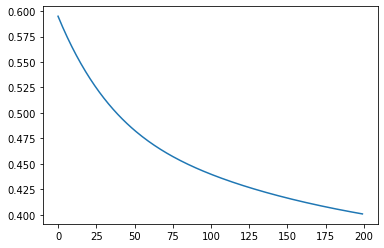

In [4]:
plt.plot(gd_cost)